<a href="https://colab.research.google.com/github/JuelGeorge/Adaptive_BCI_2D/blob/main/ConvVAE_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports:

In [38]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np
import math
from keras.losses import mean_squared_error
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda, Flatten, BatchNormalization
from keras.layers import Activation, Reshape, AveragePooling2D, UpSampling2D
from keras.layers import Conv2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Concatenate
from keras.layers import Dropout
import os
import tensorflow as tf

In [2]:
K.clear_session()

Use only for model visualization

In [14]:
%load_ext tensorboard
import tensorflow as tf
import datetime
!rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Data upload.
Events and Cz electrode only.

In [3]:
events=np.load('/content/all_events.npy')
events=events.reshape((6437))
data=np.load('/content/cz.npy')
train_data=data[:4500,:]
test_data=data[4500:,:]
train_labels=events[:4500]
test_labels=events[4500:]

he_train_labels=to_categorical(train_labels)
he_test_labels=to_categorical(test_labels)

In [4]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

Use this for all data

In [19]:
maxval_train=max(np.max(train_data),abs(np.min(train_data)))
n_train_data=[]
for i in train_data:
  n_train_data.append(i/maxval_train)
n_train_data=np.array(n_train_data)


n_test_data=[]
for i in test_data:
  n_test_data.append(i/maxval_train)
n_test_data=np.array(n_test_data)

reshaped_train_data=[]
for i in n_train_data: 
 reshaped_train_data.append(i.reshape((1,128,1)))
reshaped_train_data=np.array(reshaped_train_data)
#plt.plot(i[:,:,0].T)
reshaped_test_data=[]
for i in n_test_data: 
 reshaped_test_data.append(i.reshape((1,128,1)))
reshaped_test_data=np.array(reshaped_test_data)





Use this for only Errps

In [10]:
len(np.where(errp_indices<4500)[0])

936

In [6]:
errp_indices=np.where(events==1)[0]
errp_data=data[errp_indices,:]
errp_train_data=errp_data[:1000,:]
errp_test_data=errp_data[1000:,:]

maxval_train=max(np.max(errp_train_data),abs(np.min(errp_train_data)))
n_errp_train_data=[]
for i in errp_train_data:
  n_errp_train_data.append(i/maxval_train)
n_errp_train_data=np.array(n_errp_train_data)


n_errp_test_data=[]
for i in errp_train_data:
  n_errp_test_data.append(i/maxval_train)
n_errp_test_data=np.array(n_errp_test_data)

reshaped_errp_train_data=[]
for i in n_errp_train_data: 
 reshaped_errp_train_data.append(i.reshape((1,128,1)))
reshaped_errp_train_data=np.array(reshaped_errp_train_data)
#plt.plot(i[:,:,0].T)
reshaped_errp_test_data=[]
for i in n_errp_test_data: 
 reshaped_errp_test_data.append(i.reshape((1,128,1)))
reshaped_errp_test_data=np.array(reshaped_errp_test_data)


In [14]:
n_kernels=20
n_latent=2

Variational Autoencoder-

In [ ]:
input=keras.Input(shape=(1,128,1))
x = Conv2D(n_kernels, (1, 40), padding='same', use_bias=False)(input)
x = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(x)
x = Activation('elu')(x)
x = Conv2D(n_kernels, (1, 1), use_bias=False)(x)
x = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(x)
x = Activation('elu')(x)
x = AveragePooling2D(pool_size=(1, 2))(x)
x = Flatten()(x)
z_mean=layers.Dense(n_latent,use_bias=False)(x)
z_log_var=layers.Dense(n_latent,use_bias=False)(x)
def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=(K.shape(mu)[0], K.int_shape(mu)[1]))
            return mu + K.exp(0.5 * log_var) * epsilon
z = Lambda(sampling, name='latent')([z_mean, z_log_var])
encoder=Model(input,z)
decoder_in=Input(shape=(n_latent,))
x = Dense(int(128//2 * n_kernels), use_bias=False)(decoder_in)
x = Reshape((1, int(128//2),n_kernels))(x)
x = UpSampling2D(size=(1, 2))(x)
x = Conv2DTranspose(n_kernels, (1, 1), use_bias=False)(x)
x = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(x)
x = Activation('elu')(x)
x = Conv2DTranspose(1, (1, 40), padding='same', use_bias=False)(x)
x = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(x)
x_hat = Activation('elu')(x)

decoder=Model(decoder_in,x_hat)
z_decoded=decoder(z)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
class VAELoss(keras.layers.Layer):
  def vae_loss(self,x,z_decoded):
   mse = mean_squared_error(x, z_decoded)
   reconstruction_loss = K.mean(mse)
   kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   return K.mean(reconstruction_loss + kl_loss)

  def call(self,inputs):
    x=inputs[0]
    z_decoded=inputs[1]
    loss=self.vae_loss(x,z_decoded)
    self.add_loss(loss,inputs=inputs)
    return x
y=VAELoss()([input,z_decoded])

In [ ]:
vae=Model(input,y)
vae.compile(optimizer='Adam',loss=None)

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
vae.fit(x=reshaped_train_data,y=None,epochs=100,batch_size=100,validation_data=(reshaped_test_data,None))

Train on 6000 samples, validate on 437 samples
Epoch 1/100
6000/6000 [==============================] - ETA: 0s - loss: 0.4734

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 13s 2ms/sample - loss: 0.4734 - val_loss: 0.3244
Epoch 2/100
3700/6000 [=================>............] - ETA: 4s - loss: 0.0858


KeyboardInterrupt



Conditional VAE

In [20]:
reshaped_train_labels=[]
for i in he_train_labels: 
 reshaped_train_labels.append(i.reshape((1,3,1)))
reshaped_train_labels=np.array(reshaped_train_labels)

reshaped_test_labels=[]
for i in he_test_labels: 
 reshaped_test_labels.append(i.reshape((1,3,1)))
reshaped_test_labels=np.array(reshaped_test_labels)

In [41]:
inp=keras.Input(shape=(1,128,1))
lab=keras.Input(shape=(1,3,1))
input2=Concatenate(axis=2)([inp,lab])
x = Conv2D(n_kernels, (1, 40), padding='same', use_bias=False)(input2)
x= Dropout(0.1)(x)
x = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(x)
x = Activation('elu')(x)
x = Conv2D(n_kernels, (1, 1), use_bias=False)(x)
x= Dropout(0.1)(x)
x = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(x)
x = Activation('elu')(x)
x = AveragePooling2D(pool_size=(1, 2))(x)
x = Flatten()(x)
z_mean=layers.Dense(n_latent,use_bias=False)(x)
z_log_var=layers.Dense(n_latent,use_bias=False)(x)
def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=(K.shape(mu)[0], K.int_shape(mu)[1]))
            return mu + K.exp(0.5 * log_var) * epsilon
z = Lambda(sampling, name='latent')([z_mean, z_log_var])
encoder=Model([inp,lab],z)

decoder_in=Input(shape=(n_latent,))
flat_lab_in=Input(shape=(3,))
zc=Concatenate()([decoder_in,flat_lab_in])
x = Dense(int(128//2 * n_kernels), use_bias=False)(zc)
x= Dropout(0.1)(x)
x = Reshape((1, int(128//2),n_kernels))(x)
x = UpSampling2D(size=(1, 2))(x)
x = Conv2DTranspose(n_kernels, (1, 1), use_bias=False)(x)
x= Dropout(0.1)(x)
x = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(x)
x = Activation('elu')(x)
x = Conv2DTranspose(1, (1, 40), padding='same', use_bias=False)(x)
x= Dropout(0.1)(x)
x = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(x)
x_hat = Activation('elu')(x)
decoder=Model([decoder_in,flat_lab_in],x_hat)
flat_lab=Flatten()(lab)
z_decoded=decoder([z,flat_lab])

In [42]:
class VAELoss(keras.layers.Layer):
  def vae_loss(self,x,z_decoded):
   mse = mean_squared_error(x, z_decoded)
   reconstruction_loss = K.mean(mse)
   kl_loss = -0.1 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   return K.mean(reconstruction_loss + kl_loss)

  def call(self,inputs):
    x=inputs[0]
    z_decoded=inputs[1]
    loss=self.vae_loss(x,z_decoded)
    self.add_loss(loss,inputs=inputs)
    return x
y=VAELoss()([inp,z_decoded])

In [43]:
cvae=Model([inp,lab],y)
cvae.compile(optimizer='Adam',loss=None)

In [ ]:
cvae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 128, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 3, 1)]    0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 1, 131, 1)    0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 1, 131, 40)   1600        ['concatenate[0][0]']      

Use only for Dataviz.

In [37]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

In [44]:
checkpoint_path = "training_1/Dropout_100Epochs_50BS.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [45]:
history=cvae.fit(x=[reshaped_train_data,reshaped_train_labels],y=None,epochs=100,batch_size=50,validation_data=([reshaped_test_data,reshaped_test_labels],None),callbacks=[cp_callback])


Train on 4500 samples, validate on 1937 samples
Epoch 1/100
4500/4500 [==============================] - ETA: 0s - loss: 0.2968

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: saving model to training_1/Dropout_100Epochs_50BS.ckpt
4500/4500 [==============================] - 7s 2ms/sample - loss: 0.2968 - val_loss: 0.1457
Epoch 2/100
4450/4500 [============================>.] - ETA: 0s - loss: 0.1009
Epoch 2: saving model to training_1/Dropout_100Epochs_50BS.ckpt
4500/4500 [==============================] - 4s 894us/sample - loss: 0.1008 - val_loss: 0.0962
Epoch 3/100
4500/4500 [==============================] - ETA: 0s - loss: 0.0736
Epoch 3: saving model to training_1/Dropout_100Epochs_50BS.ckpt
4500/4500 [==============================] - 5s 1ms/sample - loss: 0.0736 - val_loss: 0.0807
Epoch 4/100
4450/4500 [============================>.] - ETA: 0s - loss: 0.0606
Epoch 4: saving model to training_1/Dropout_100Epochs_50BS.ckpt
4500/4500 [==============================] - 4s 884us/sample - loss: 0.0605 - val_loss: 0.0703
Epoch 5/100
4450/4500 [============================>.] - ETA: 0s - loss: 0.0517
Epoch 5: saving model to training_1/Dropout_100

Use for model visualization through TensorBoard

In [ ]:
#cvae_disp=Model([inp,lab],y)
#cvae_disp.compile(optimizer='Adam',loss=None)
#cvae_disp.fit(x=[reshaped_train_data,reshaped_train_labels],y=None,epochs=5,batch_size=10,validation_data=None,callbacks=[tensorboard_callback])


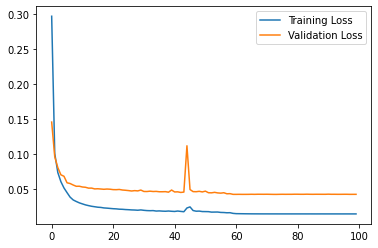

In [46]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Common code to explore embeddings

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


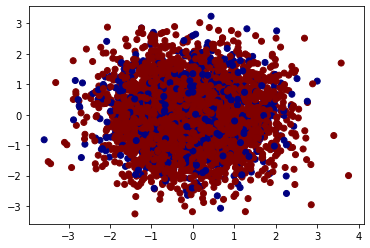

In [47]:
z_train = encoder.predict([reshaped_train_data,reshaped_train_labels])
encodings= np.asarray(z_train)
encodings = encodings.reshape(reshaped_train_data.shape[0], 2)
plt.scatter(encodings[:, 0], encodings[:, 1], c=train_labels, cmap=plt.cm.jet)
plt.show()

In [48]:
#x_dec=decoder.predict(encodings)
embedding_sample=np.array([0,0]).reshape((1,2))
hot_encoded_nonerrp=np.array([0.,0.,1.]).reshape((1,3))
hot_encoded_errp=np.array([0.,1.,0.]).reshape((1,3))
decoded_nonerrp=decoder.predict([embedding_sample,hot_encoded_nonerrp])
decoded_errp=decoder.predict([embedding_sample,hot_encoded_errp])
diff=decoded_errp-decoded_nonerrp

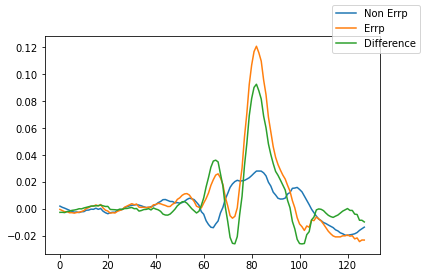

In [49]:
#plt.plot(x_dec[550,:,:,0].T)
ax1,=plt.plot(decoded_nonerrp[0,0,:,0])
ax2,=plt.plot(decoded_errp[0,0,:,0])
ax3,=plt.plot(diff[0,0,:,0])
ax1.set_label("Non Errp")
ax2.set_label("Errp")
ax3.set_label("Difference")
"""
ax2,=plt.plot(trial2[0,0,:,0])
ax3,=plt.plot(trial3[0,0,:,0])
ax4,=plt.plot(trial4[0,0,:,0])
ax5,=plt.plot(trial5[0,0,:,0])
ax6,=plt.plot(trial6[0,0,:,0])
ax1.set_label("3,3")
ax2.set_label("-3,-3")
ax3.set_label("-3,3")
ax4.set_label("1,-1")
ax5.set_label("1,-2")
ax6.set_label("0,0")
plt.figlegend()
"""
plt.figlegend()
plt.show()

In [ ]:
%tensorboard --logdir logs/fit

In [89]:
encoder.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 1, 128, 1)]  0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 1, 3, 1)]    0           []                               
                                                                                                  
 concatenate_10 (Concatenate)   (None, 1, 131, 1)    0           ['input_21[0][0]',               
                                                                  'input_22[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 1, 131, 20)   800         ['concatenate_10[0][0]']  

In [88]:
decoder.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 concatenate_11 (Concatenate)   (None, 5)            0           ['input_23[0][0]',               
                                                                  'input_24[0][0]']               
                                                                                                  
 dense_17 (Dense)               (None, 1280)         6400        ['concatenate_11[0][0]']  

In [50]:
a=np.linspace(-3,3,num=5)

In [16]:
%matplotlib inline

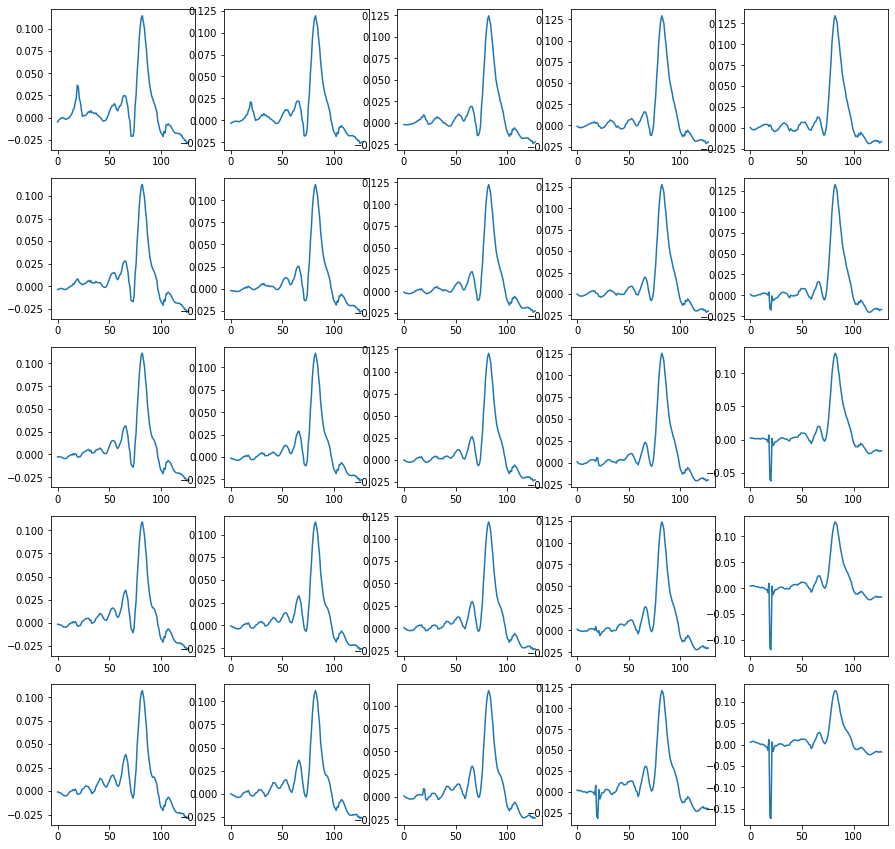

In [51]:

k=1
nonerrp_he=np.array([0.,0.,1.]).reshape((1,3))
errp_he=np.array([0.,1.,0.]).reshape((1,3))
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i in a:
  for j in a:
   emb=np.array([i,j]).reshape((1,2))
   errp_sample=decoder.predict([emb,errp_he])
   plt.subplot(5,5,k)
   plt.plot(errp_sample[0,0,:,0])
   k+=1


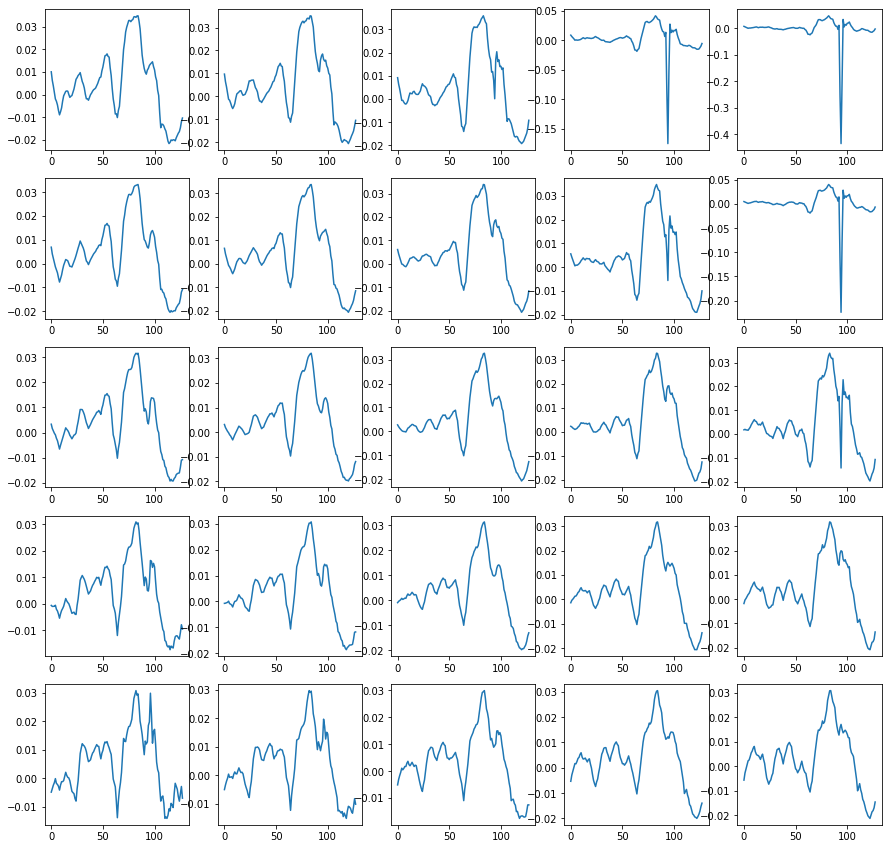

In [35]:
k=1
nonerrp_he=np.array([0.,0.,1.]).reshape((1,3))
errp_he=np.array([0.,1.,0.]).reshape((1,3))
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i in a:
  for j in a:
   emb=np.array([i,j]).reshape((1,2))
   errp_sample=decoder.predict([emb,nonerrp_he])
   plt.subplot(5,5,k)
   plt.plot(errp_sample[0,0,:,0])
   k+=1
